In [10]:
import itertools

import jax
import jax.numpy as jnp
from jax import lax, vmap, jit, grad
from jax.tree_util import tree_unflatten, tree_flatten
from itertools import chain, combinations, combinations_with_replacement, product
from jax import random as rnd
import pandas as pd

import math
from jax.scipy.special import erfc

from nn_ansatz.sampling import create_sampler
from nn_ansatz.ansatz import create_wf
from nn_ansatz.parameters import initialise_params, initialise_d0s, expand_d0s
from nn_ansatz.systems import SystemAnsatz
from nn_ansatz.pretraining import pretrain_wf
from nn_ansatz.vmc import create_energy_fn, create_grad_function
# fro .utils import *
from nn_ansatz.utils import Logging, load_pk, save_pk

In [1]:

def vector_sub(v1, v2, axis=-2):
    return jnp.expand_dims(v1, axis=axis) - jnp.expand_dims(v2, axis=axis-1)

def vector_add(v1, v2, axis=-2):
    return jnp.expand_dims(v1, axis=axis) + jnp.expand_dims(v2, axis=axis-1)

def compute_distances(v1, v2):
    inter_vector = vector_sub(v1, v2)
    return jnp.sqrt(jnp.sum(inter_vector**2, axis=-1))

def inner(v1, v2):
    return jnp.sum(v1 * v2, axis=-1)

def generate_real_lattice(real_basis, nimgs):
    # from pyscf, some logic to set the number of imgs away from simulation cell. Adapted version confirmed in notio
    img_range = jnp.arange(-nimgs, nimgs+1)
    img_sets = list(product(*[img_range, img_range, img_range]))
    # first axis is the number of lattice vectors, second is the integers to scale the primitive vectors, third is the resulting set of vectors
    # then sum over those
    # print(len(img_sets))
    img_sets = jnp.concatenate([jnp.array(x)[None, :, None] for x in img_sets if not jnp.sum(jnp.array(x) == 0) == 3], axis=0)
    # print(img_sets.shape)
    imgs = jnp.sum(img_sets * real_basis, axis=1)
    
    # generate all the single combinations of the basis vectors
    v = jnp.split(real_basis, 3, axis=0)
    z = jnp.zeros_like(v[0])
    vecs = product(*[[-v[0], z, v[0]],[-v[1], z, v[1]], [-v[2], z, v[2]]])
    vecs = jnp.array(list(vecs)).squeeze().sum(-2)  # sphere around the origin

    # if a sphere around the image is within rcut then keep it
    lengths = jnp.linalg.norm(vecs[None, ...] + imgs[:, None, :], axis=-1)
    rcut = nimgs * jnp.linalg.norm(real_basis, axis=1)[0]
    mask = jnp.any(lengths < rcut, axis=1)
    nimgs = len(imgs)
    imgs = imgs[mask]
    return imgs

def generate_reciprocal_lattice(reciprocal_basis, mesh):
    # 3D uniform grids
    rx = jnp.fft.fftfreq(mesh[0], 1./mesh[0])
    ry = jnp.fft.fftfreq(mesh[1], 1./mesh[1])
    rz = jnp.fft.fftfreq(mesh[2], 1./mesh[2])
    base = (rx, ry, rz)
    cartesian_product = jnp.array(list(product(*base)))  # another worse version of this is available in cartesian_prod(...)
    cartesian_product = jnp.array([x for x in cartesian_product if not jnp.sum(x == 0) == 3])  # filter the zero vector
    reciprocal_lattice = jnp.dot(cartesian_product, reciprocal_basis)
    return reciprocal_lattice

In [2]:
# seed=0
# n_walkers = 64
# key = rnd.PRNGKey(seed)
# mol = SystemAnsatz(jnp.array([[0.25, 0.25, 0.25]]),
#                                 jnp.array([3.]),
#                                 3,
#                                 unit_cell_length=7.407726,
#                                 real_basis=jnp.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]]),
#                                 periodic_boundaries=True,
#                                 n_el_atoms=[3],
#                                 n_layers=2,
#                                 n_sh=32,
#                                 n_ph=8,
#                                 n_det=4,
#                                 kappa=2.,
#                                 real_cut=4.,
#                                 reciprocal_cut=8)

# wf, kfac_wf, wf_orbitals = create_wf(mol)
# params = initialise_params(key, mol)
# d0s = expand_d0s(initialise_d0s(mol), n_walkers)
# sampler, equilibrate = create_sampler(wf, mol, correlation_length=10)
# walkers = mol.initialise_walkers(n_walkers=n_walkers)
# params, walkers = pretrain_wf(params,
#                             wf,
#                             wf_orbitals,
#                             mol,
#                             walkers,
#                             n_it=500,
#                             lr=1e-3,
#                             n_eq_it=500,
#                             pre_path='./pre4ewald.pk')

# params, walkers = load_pk(pre_path)
# walkers = equilibrate(params, walkers, d0s, key, n_it=1000, step_size=0.02 ** 2)

In [26]:
def compute_potential_energy_solid_i(walkers, r_atoms, z_atoms, real_lattice, kappa, q_q, charges, volume, rl_factor, reciprocal_lattice):

    """
    :param walkers (n_el, 3):
    :param r_atoms (n_atoms, 3):
    :param z_atoms (n_atoms, ):

    Pseudocode:
        - compute the potential energy (pe) of the cell
        - compute the pe of the cell electrons with electrons outside
        - compute the pe of the cell electrons with nuclei outside
        - compute the pe of the cell nuclei with nuclei outside
    """
    # put the walkers and r_atoms together
    walkers = jnp.concatenate([r_atoms, walkers], axis=0)  # (n_particle, 3)

    # compute the Rs0 term
    p_p_vectors = vector_sub(walkers, walkers)
    p_p_distances = compute_distances(walkers, walkers)
    # p_p_distances[p_p_distances < 1e-16] = 1e200  # doesn't matter, diagonal dropped, this is just here to suppress the error
    Rs0 = jnp.tril(erfc(kappa * p_p_distances) / p_p_distances, k=-1)  # is half the value

    # compute the Rs > 0 term
    ex_walkers = vector_add(walkers, real_lattice)  # (n_particle, n_lattice, 3)
    tmp = walkers[:, None, None, :] - ex_walkers[None, ...]  # (n_particle, n_particle, n_lattice, 3)
    ex_distances = jnp.sqrt(jnp.sum(tmp**2, axis=-1))  
    Rs1 = jnp.sum(erfc(kappa * ex_distances) / ex_distances, axis=-1)
    real_sum =  (q_q * (Rs0 + 0.5 * Rs1)).sum((-1, -2))
    
    # compute the constant factor
    self_interaction = - 0.5 * jnp.diag(q_q * 2 * kappa / jnp.sqrt(jnp.pi)).sum()
    constant = - 0.5 * charges.sum()**2 * jnp.pi / (kappa**2 * volume)  # is zero in neutral case

    # compute the reciprocal term reuse the ee vectors
    exp = jnp.real(jnp.sum(rl_factor[None, None, :] * jnp.exp(1j * p_p_vectors @ jnp.transpose(reciprocal_lattice)), axis=-1))
    reciprocal_sum = 0.5 * (q_q * exp).sum((-1,-2))
    
    potential = real_sum + reciprocal_sum + constant + self_interaction
    return real_sum, reciprocal_sum, potential

compute_potential_energy = jit(vmap(compute_potential_energy_solid_i, in_axes=(0, None, None, None, None, None, None, None, None, None)))

In [5]:
# seed=0
# n_walkers = 64
# key = rnd.PRNGKey(seed)
# mol = SystemAnsatz(jnp.array([[0.25, 0.25, 0.25]]),
#                                 jnp.array([3.]),
#                                 3,
#                                 unit_cell_length=7.407726,
#                                 real_basis=jnp.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]]),
#                                 periodic_boundaries=True,
#                                 n_el_atoms=[3],
#                                 n_layers=2,
#                                 n_sh=32,
#                                 n_ph=8,
#                                 n_det=4,
#                                 kappa=2.,
#                                 real_cut=4.,
#                                 reciprocal_cut=8)
# wf, kfac_wf, wf_orbitals = create_wf(mol)
# params = initialise_params(key, mol)
# d0s = expand_d0s(initialise_d0s(mol), n_walkers)
# sampler, equilibrate = create_sampler(wf, mol, correlation_length=10)
# walkers = mol.initialise_walkers(n_walkers=n_walkers)
# 
# walkers = equilibrate(params, walkers, d0s, key, n_it=1000, step_size=0.02 ** 2)

In [29]:

params, walkers = load_pk('./pre4ewald.pk')

mol = SystemAnsatz(jnp.array([[0.25, 0.25, 0.25]]),
                                jnp.array([3.]),
                                3,
                                unit_cell_length=7.407726,
                                real_basis=jnp.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]]),
                                periodic_boundaries=True,
                                n_el_atoms=[3],
                                n_layers=2,
                                n_sh=32,
                                n_ph=8,
                                n_det=4,
                                kappa=1.,
                                reciprocal_cut=10,
                                real_cut=5.)

kappas = jnp.linspace(0.1, 1.5, 30)
real_cuts = jnp.arange(2, 17)
reciprocal_cuts = jnp.arange(2, 17)

e_charges = jnp.array([-1. for i in range(mol.n_el)])
charges = jnp.concatenate([mol.z_atoms, e_charges], axis=0)  # (n_particle, )
q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)

results_run2 = []
for k in kappas:
    for r in real_cuts:
        real_lattice = generate_real_lattice(mol.real_basis, r)  # (n_lattice, 3)
        for rp in reciprocal_cuts:

            mesh = [rp for i in range(3)]
            reciprocal_lattice = generate_reciprocal_lattice(mol.reciprocal_basis, mesh)
            rl_inner_product = inner(reciprocal_lattice, reciprocal_lattice)
            rl_factor = (4*jnp.pi / mol.volume) * jnp.exp(- rl_inner_product / (4*k**2)) / rl_inner_product  

            print(k, r, rp, float(mol.volume), mol.n_el)
            real_sum, reciprocal_sum, energy = compute_potential_energy(walkers, mol.r_atoms, mol.z_atoms, real_lattice, k, q_q,                                                                            charges, mol.volume, rl_factor, reciprocal_lattice)
            x = [k, r, rp, float(real_sum.mean()), float(reciprocal_sum.mean()), float(energy.mean())]
            print(x)
            results_run2.append(x)




664, -6.136956214904785]
1.5 4 4 203.24725341796875 3
[1.5, 4, 4, 0.30860739946365356, 4.598250389099121, -5.248554229736328]
1.5 4 5 203.24725341796875 3
[1.5, 4, 5, 0.30860739946365356, 6.047544956207275, -3.7992591857910156]
1.5 4 6 203.24725341796875 3
[1.5, 4, 6, 0.30860739946365356, 6.487874507904053, -3.3589305877685547]
1.5 4 7 203.24725341796875 3
[1.5, 4, 7, 0.30860739946365356, 7.07055139541626, -2.776252508163452]
1.5 4 8 203.24725341796875 3
[1.5, 4, 8, 0.30860739946365356, 7.2383928298950195, -2.608412027359009]
1.5 4 9 203.24725341796875 3
[1.5, 4, 9, 0.30860739946365356, 7.434978008270264, -2.411825656890869]
1.5 4 10 203.24725341796875 3
[1.5, 4, 10, 0.30860739946365356, 7.484951019287109, -2.36185359954834]
1.5 4 11 203.24725341796875 3
[1.5, 4, 11, 0.30860739946365356, 7.539366722106934, -2.3074374198913574]
1.5 4 12 203.24725341796875 3
[1.5, 4, 12, 0.30860739946365356, 7.551637172698975, -2.2951672077178955]
1.5 4 13 203.24725341796875 3
[1.5, 4, 13, 0.308607399463

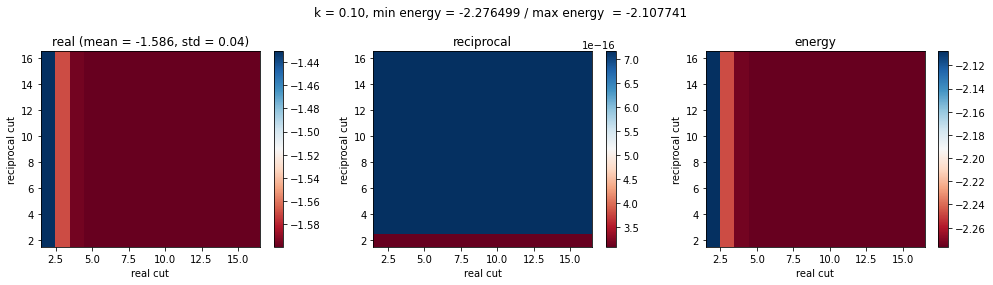

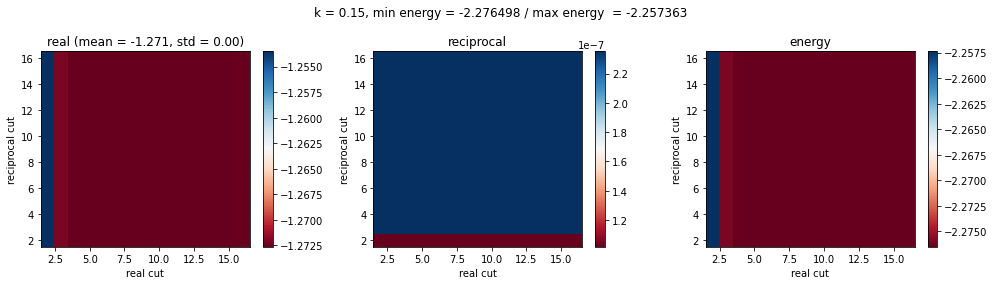

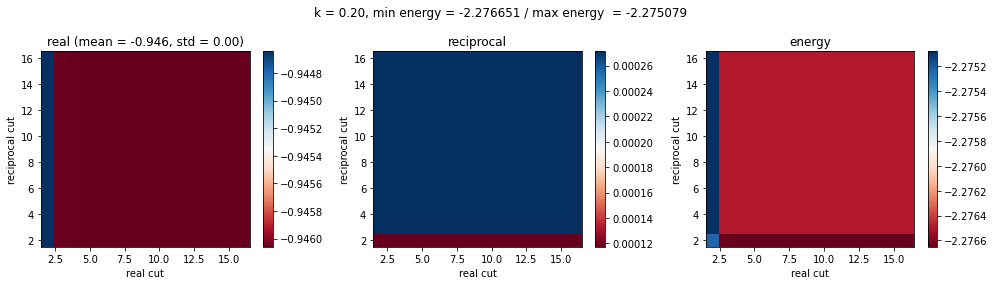

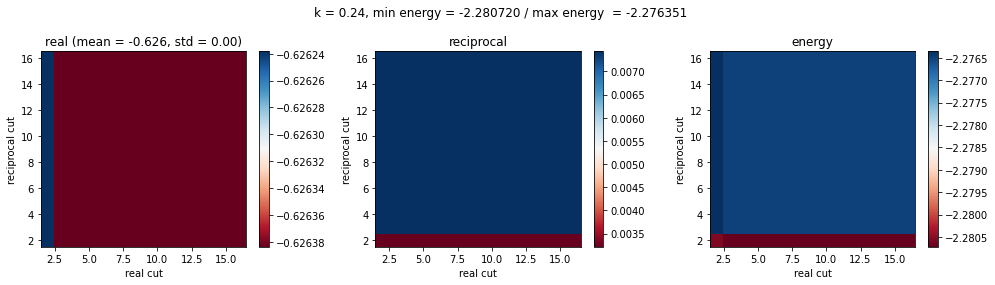

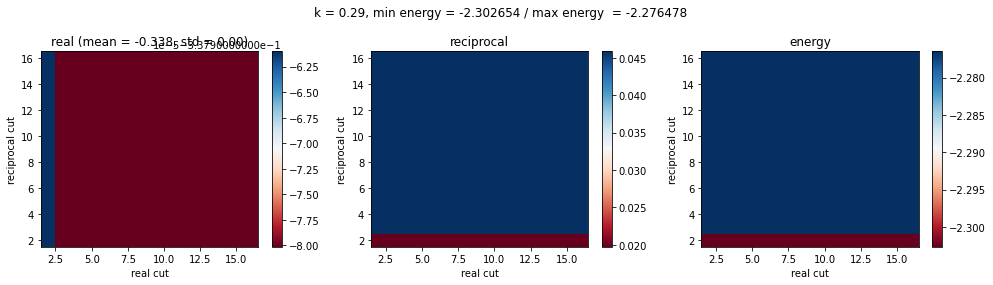

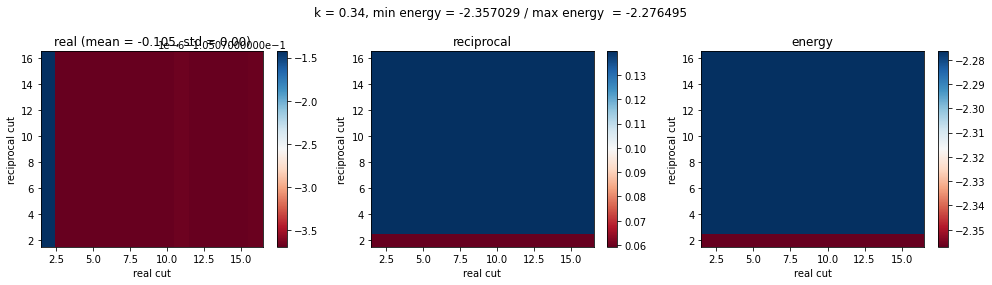

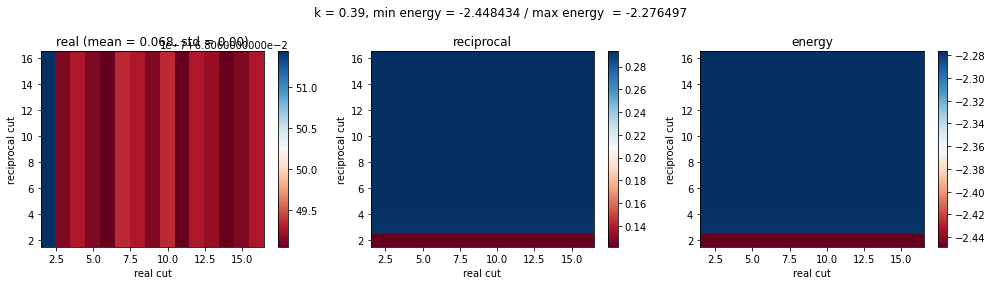

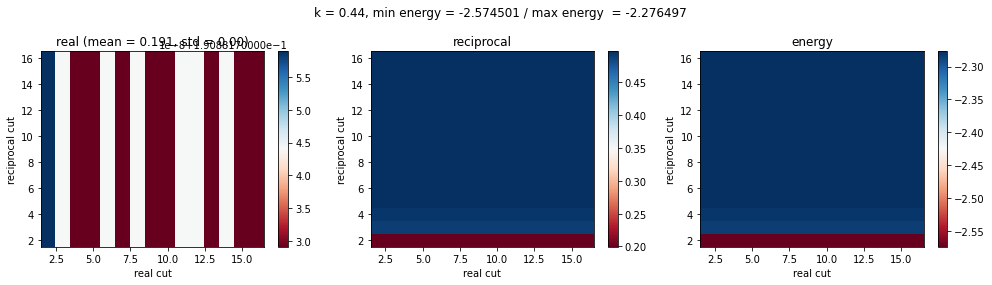

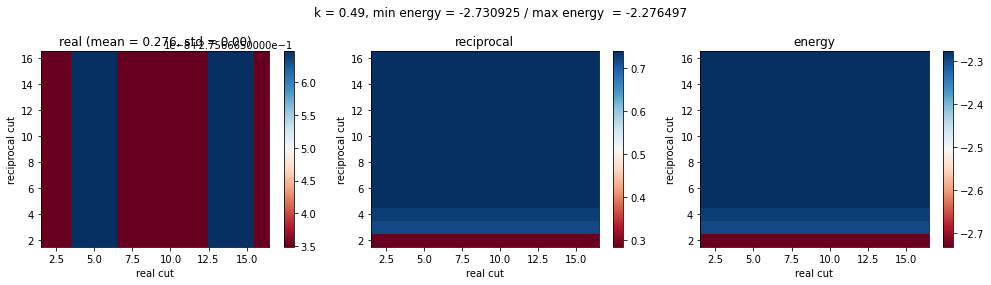

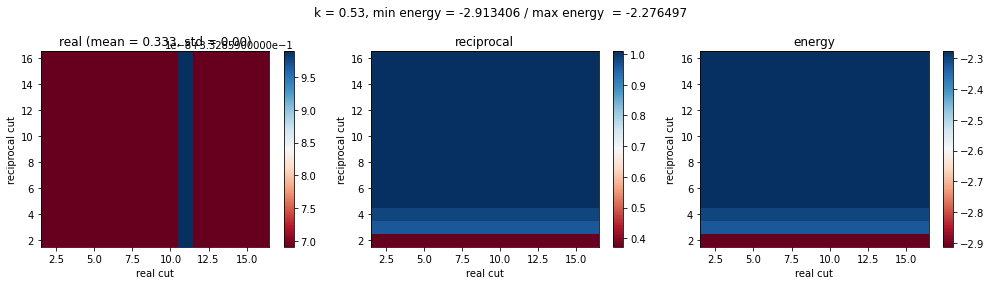

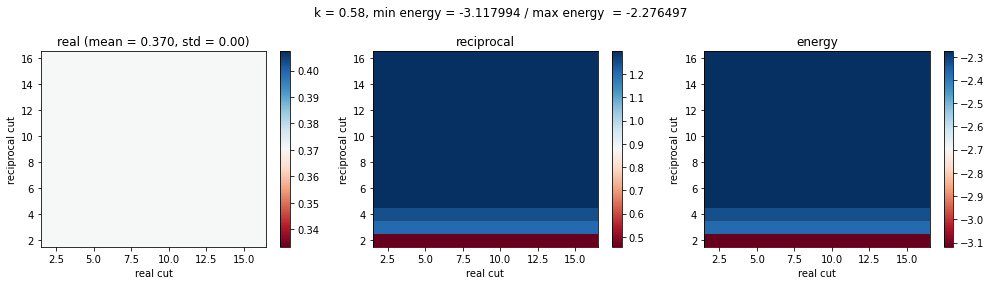

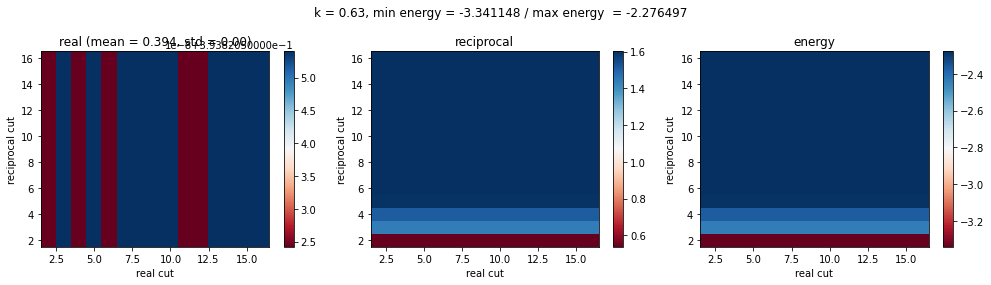

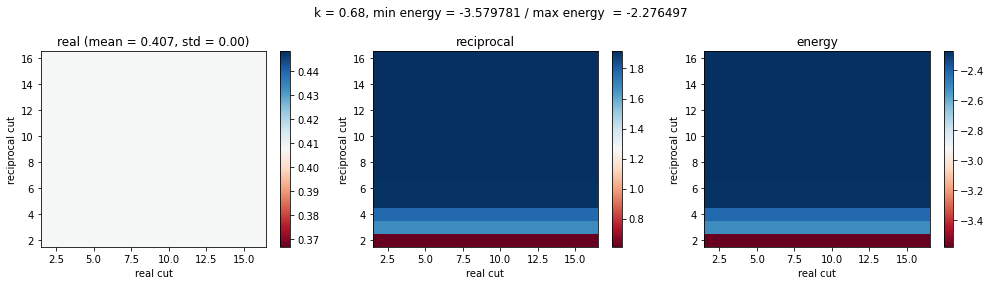

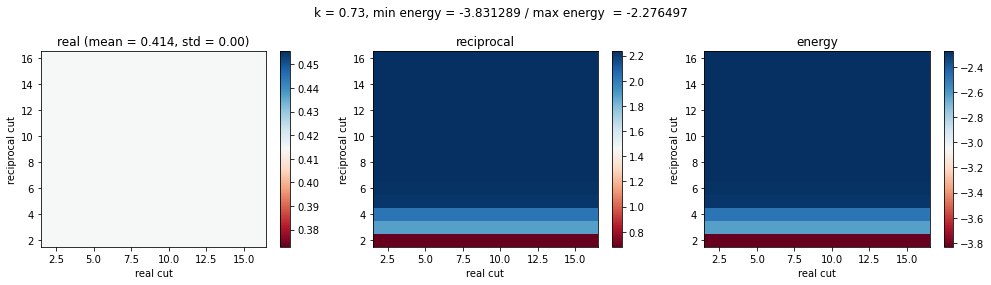

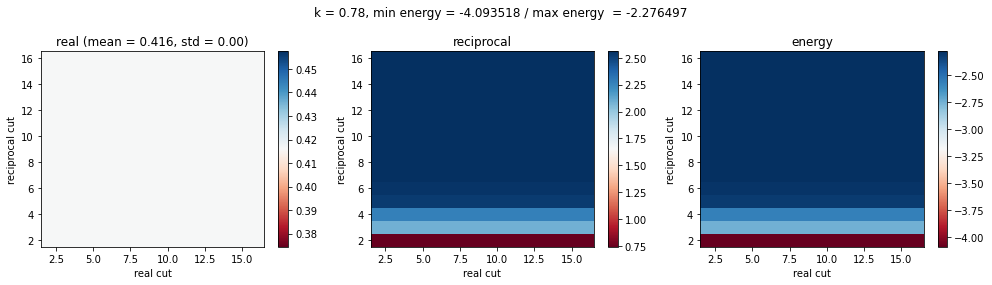

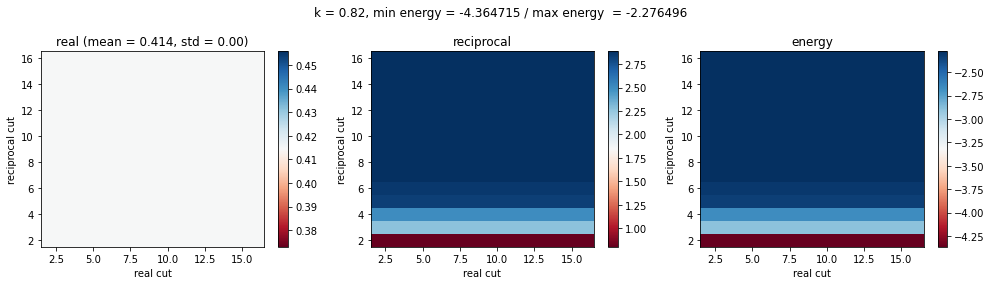

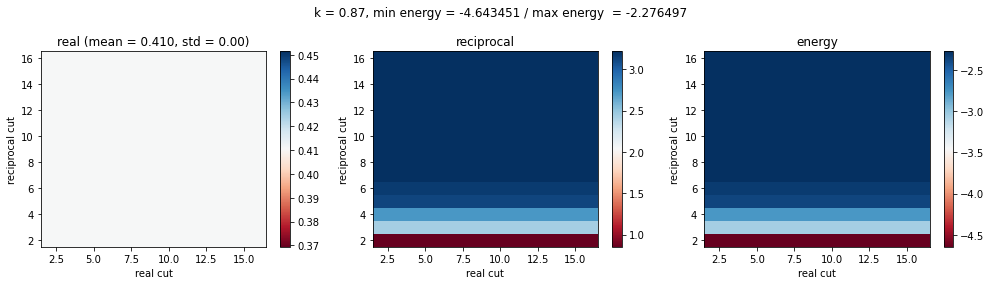

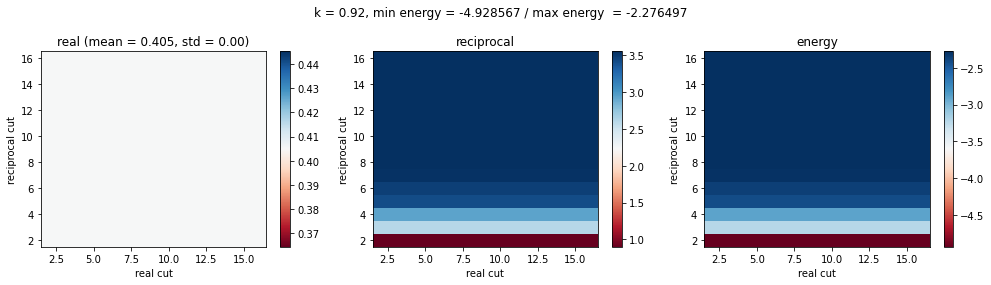

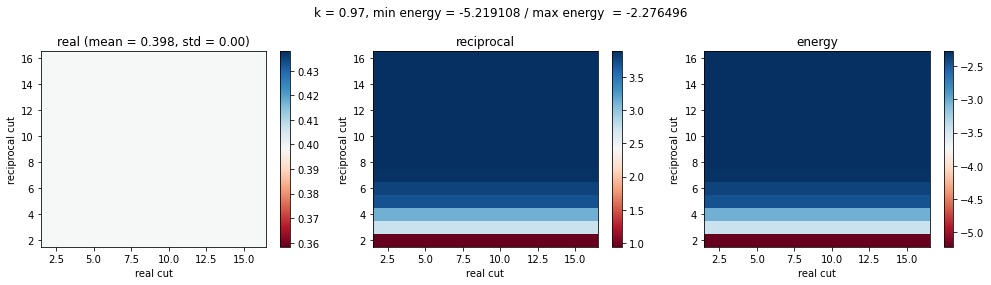

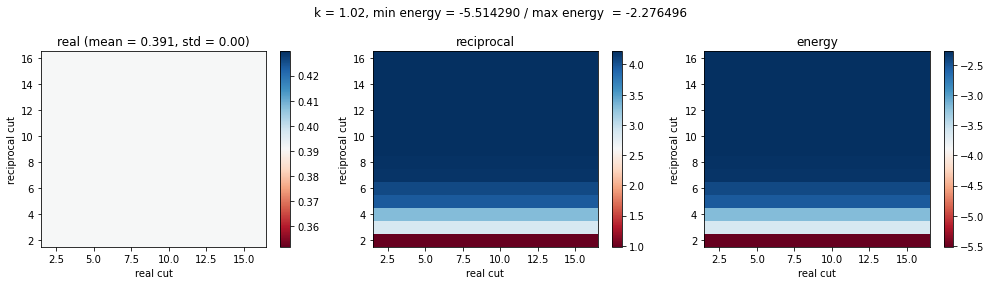

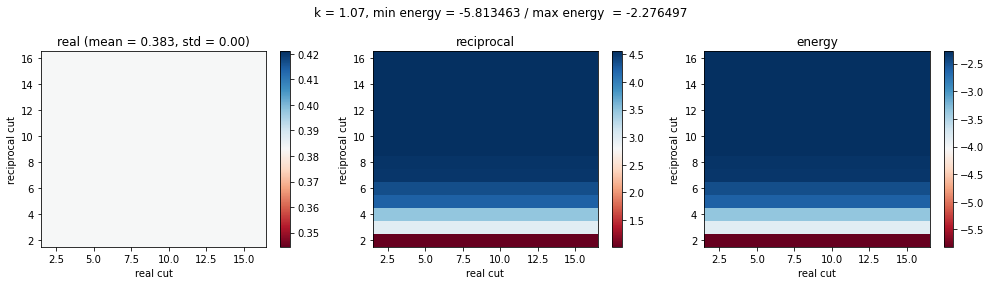

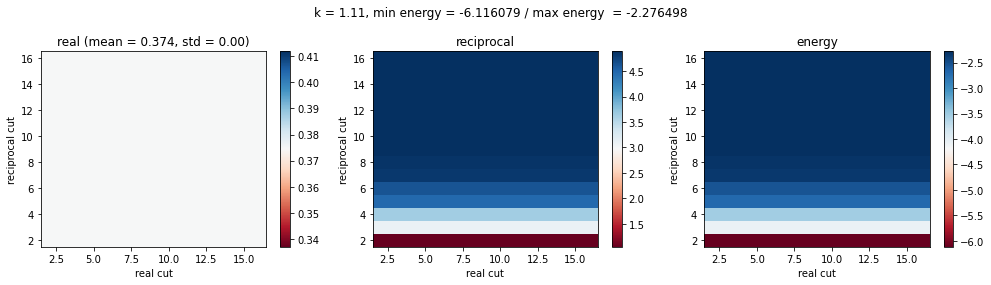

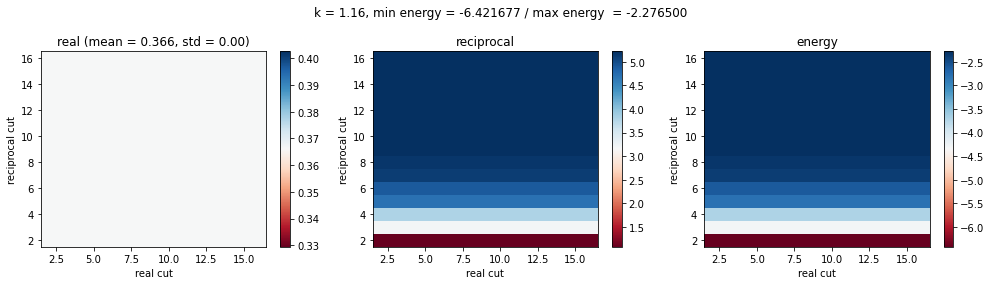

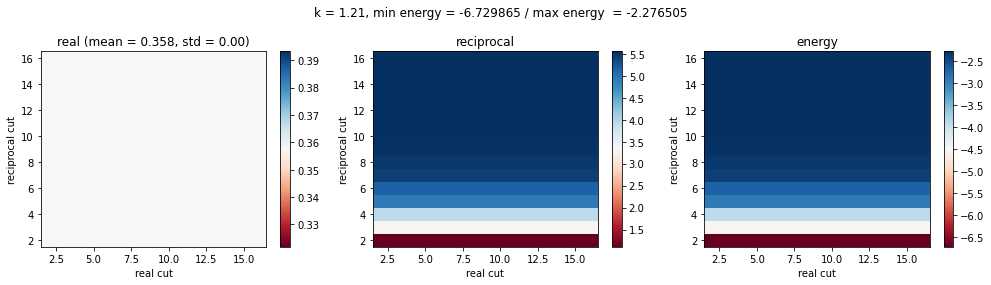

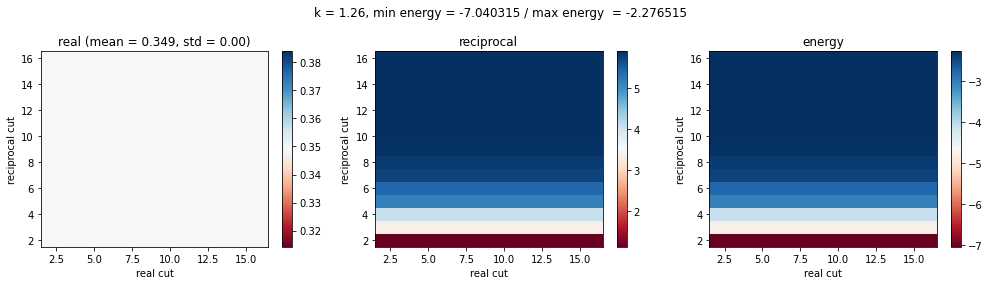

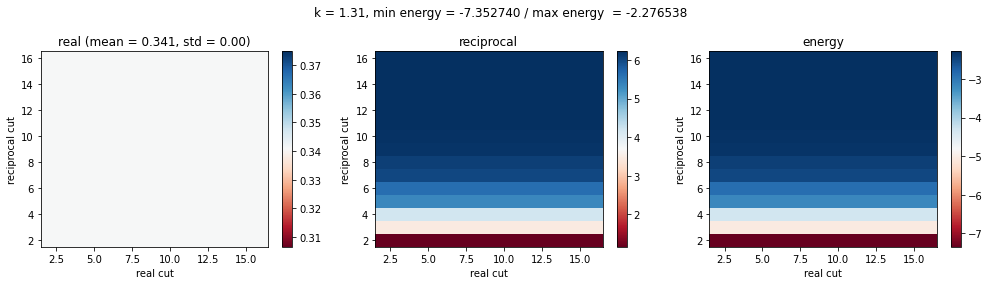

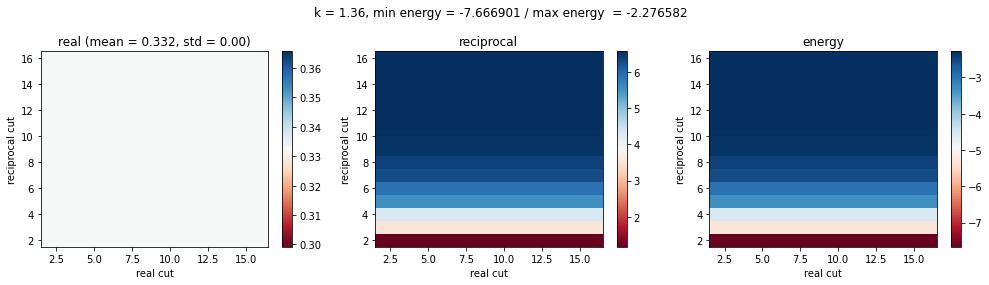

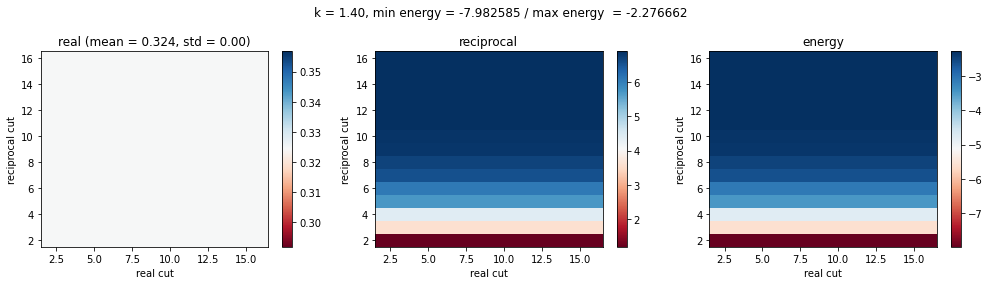

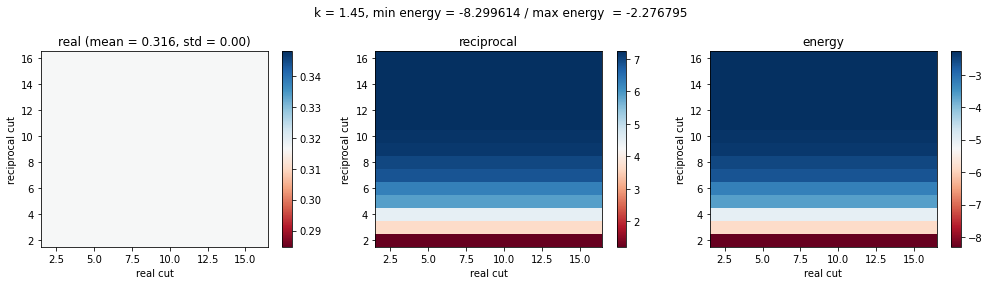

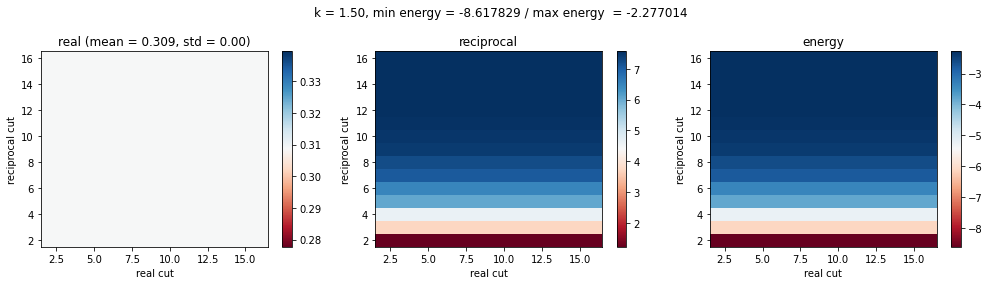

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
results2 = pd.DataFrame(results_run2, columns=['k', 'r', 'rp', 'real', 'reciprocal', 'energy'])
X, Y = np.meshgrid(real_cuts, reciprocal_cuts)

for k in kappas:
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    for z, ax in zip(['real', 'reciprocal', 'energy'], axs):
        data = results2[results2.k == k].pivot(index='rp', columns='r', values=z)
        # print(data, '\n')
        p = ax.pcolor(X, Y, data.values, cmap=cm.RdBu, vmin=data.min().min(), vmax=data.max().max(), shading='auto')
        ax.set_xlabel('real cut')
        ax.set_ylabel('reciprocal cut')
        if z == 'real': z = 'real (mean = %.3f, std = %.2f)' % (np.mean(data.values), np.std(data.values))
        ax.set_title(z)
        cb = fig.colorbar(p, ax=ax)
    fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f' % (k, data.min().min(), data.max().max()))
    fig.tight_layout()
        
    plt.show()

In [67]:
def test(walkers, nimgs):
    x = t2(nimgs)
    return x
    
def t2(nimgs):
    img_range = jnp.arange(-nimgs, nimgs+1)
    img_sets = list(product(*[img_range, img_range, img_range]))
    return img_sets

test = vmap(jit(test, static_argnums=(1,)), in_axes=(0, None))

x = test(walkers, 1)
print(x[0])

(DeviceArray([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1], dtype=int32), DeviceArray([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1], dtype=int32), DeviceArray([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
             -1, -1, -1, -1], dtype

In [80]:
print(mol.reciprocal_height)

0.025771827
